In [1]:
import pandas as pd
import numpy as np
import math
import operator
import pprint

import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
from IPython.display import display, Image

In [2]:
df=pd.read_csv('weather.csv',index_col=0)
df

,Outlook,Temparature,Humidty,Wind,Play_Tennis
Day,,,,,
Day1,Sunny,Hot,High,Weak,NO
Day2,Sunny,Hot,High,Strong,NO
Day3,Overcast,Hot,High,Weak,YES
Day4,Rain,Mild,High,Weak,YES
Day5,Rain,Cool,Normal,Weak,YES
Day6,Rain,Cool,Normal,Strong,NO
Day7,Overcast,Cool,Normal,Strong,YES
Day8,Sunny,Mild,High,Weak,NO
Day9,Sunny,Cool,Normal,Weak,YES


In [3]:
def Entropy(df):
    target=df.columns[-1]
    entropy=0
    for val in df[target].unique():
        count=df[(df[target]==val)].count().iloc[0]/len(df)
        entropy+=-count*math.log(count,2)
    return  round(entropy,4)

In [4]:
def Entropy_column(df,col):
    target=df.columns[-1]
    temp=[]
    for val in df[col].unique():
        entropy=0
        for label in df[target].unique():
            n=int(df[(df[col]==val) & (df[target]==label)].count()[col])
            total=len(df[(df[col]==val)])
            fraction=n/total
            if(fraction==0):
                entropy+=0
            else:
                entropy+=-fraction*math.log(fraction,2)
        temp.append(round(entropy,3))
    return temp

In [5]:
def treeNode(df):
    E=Entropy(df)
    IG = []
    IG2={}
    for col in df.columns[:-1]:
        entropy=Entropy_column(df,col)
        IG.append(E-sum(entropy)/len(entropy))
        IG2[col]=E-sum(entropy)/len(entropy)
    inverse = [(value, key) for key, value in IG2.items()]
    return max(inverse)[1]
    
    """print(df.keys()[:-1][np.argmax(IG)])
    print(IG)
    print(max(inverse)[1])
    print(IG2)
    return df.keys()[:-1][np.argmax(IG)]"""

In [6]:
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)

In [7]:
edgs=[]
leaf_nodes={}
yes_labels=iter(['Yes','True','yes','true'])
no_labels=iter(['No','no','False','false'])
def buildTree(df,tree=None): 
    target = np.array(df.columns[-1:])[0] #target-variable

    #get feature of max IG
    node = treeNode(df)

    #get unique values of node
    attValues = df[node].unique()
    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
    #loop to construct a tree by calling this function recursively. 
    for value in attValues:
        
        #subset of df after root node
        subtable = get_subtable(df,node,value)

        #get target variables with there count
        clValue,counts = np.unique(subtable[target],return_counts=True)
        edgs.append((node,value))
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]
            
            if(clValue[0]=='YES' and value not in leaf_nodes):
                leaf_nodes[value]=next(yes_labels)
                #edgs.append((value,next(yes_labels)))
            elif(clValue[0]=='NO' and value not in leaf_nodes):
                #edgs.append((value,next(no_labels)))
                leaf_nodes[value]=next(no_labels)
            
        else:
            tree[node][value] = buildTree(subtable) #Calling the function recursively
            #print(np.array(buildTree(subtable).keys()))
            edgs.append((value,next(iter(buildTree(subtable)))))
    return tree

In [37]:
tree=buildTree(df)

pprint.pprint(tree)

{'Outlook': {'Overcast': 'YES',
             'Rain': {'Wind': {'Strong': 'NO', 'Weak': 'YES'}},
             'Sunny': {'Humidty': {'High': 'NO', 'Normal': 'YES'}}}}


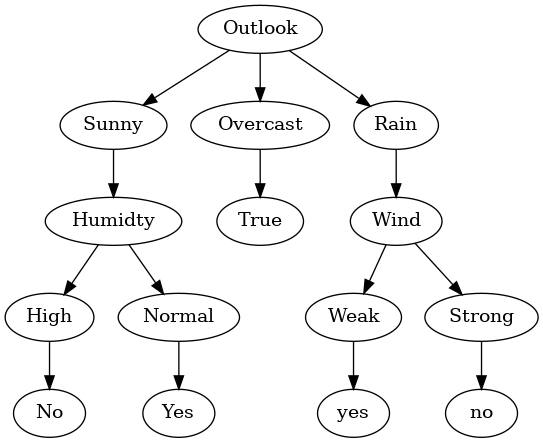

In [38]:
g=nx.DiGraph()
"""#g.add_edges_from([('Outlook','Sunny'), ('Outlook','Overcast'), ('Outlook','Rain'),
                  ('Sunny','Humidty'), ('Rain','Wind'), ('Overcast','Yess'),
                 ('Humidty','High'),('Humidty','Normal'), ('Wind','Strong'), ('Wind','Weak'),
                 ('High','No'),('Normal','Yes'),('Strong','Nooo'),('Weak','Yesss')])"""

edgs=edgs+[(k, v) for k, v in leaf_nodes.items()]
g.add_edges_from(edgs)
p=nx.drawing.nx_pydot.to_pydot(g)
p.write_png('mydecisiontree_024.png')
display(Image(filename='mydecisiontree_024.png'))